In [198]:
from datetime import date, datetime, timedelta

from binance.binance_k_line_repository import load_k_lines

interval_days = 10
interval_minutes = interval_days * 24 * 60
interval_date_from: date = date.today() - timedelta(days=3 + interval_days - 1)
interval_date_to: date = date.today() - timedelta(days=3)

symbol: str = "ETHUSDT"

raw_k_lines = load_k_lines(symbol, interval_date_from, interval_date_to)

display(raw_k_lines)

,open_timestamp_millis,open_price,high_price,low_price,close_price,volume,close_timestamp_millis,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1684713600000,1803.90,1804.00,1803.31,1803.77,1756.133,1684713659999,3.167527e+06,1637,1190.912,2.148063e+06,0
1,1684713660000,1803.77,1805.26,1803.24,1804.99,3594.532,1684713719999,6.485850e+06,2740,2722.652,4.912762e+06,0
2,1684713720000,1804.99,1805.00,1803.40,1803.85,1716.957,1684713779999,3.097751e+06,1732,602.027,1.086080e+06,0
3,1684713780000,1803.85,1804.03,1803.51,1804.00,1148.014,1684713839999,2.070760e+06,948,628.744,1.134042e+06,0
4,1684713840000,1804.00,1804.20,1803.99,1804.20,495.511,1684713899999,8.939275e+05,489,262.839,4.741842e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1685577300000,1873.17,1874.41,1873.08,1874.41,4202.478,1685577359999,7.873024e+06,1590,2667.404,4.997601e+06,0
1436,1685577360000,1874.40,1874.41,1872.54,1872.80,3444.416,1685577419999,6.454170e+06,1565,401.812,7.527455e+05,0
1437,1685577420000,1872.81,1873.44,1872.64,1872.84,1423.699,1685577479999,2.666499e+06,1428,820.822,1.537314e+06,0
1438,1685577480000,1872.84,1872.95,1872.53,1872.83,820.012,1685577539999,1.535584e+06,910,353.406,6.618053e+05,0


In [199]:
import pandas as pd

k_lines = raw_k_lines[["close_price"]]
k_lines.index = pd.to_datetime(raw_k_lines["open_timestamp_millis"], unit="ms")
k_lines.index.name = "open_datetime"

k_lines

,close_price
open_datetime,
2023-05-22 00:00:00,1803.77
2023-05-22 00:01:00,1804.99
2023-05-22 00:02:00,1803.85
2023-05-22 00:03:00,1804.00
2023-05-22 00:04:00,1804.20
...,...
2023-05-31 23:55:00,1874.41
2023-05-31 23:56:00,1872.80
2023-05-31 23:57:00,1872.84


In [200]:
from numpy import float16, float64


assert len(k_lines) == interval_minutes

assert len(k_lines[k_lines.isna().any(axis=1)]) == 0
assert len(k_lines[k_lines.isnull().any(axis=1)]) == 0

assert k_lines.dtypes["close_price"] == float64
assert len(k_lines[k_lines["close_price"] <= 0]) == 0

assert (
    (k_lines.index.to_series() - k_lines.index.to_series().shift(1))
    .iloc[1:]
    .dt.total_seconds()
    == 60
).all()

<Axes: xlabel='open_datetime'>

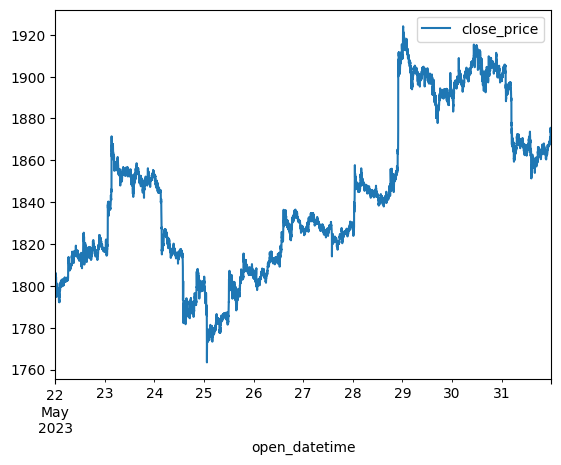

In [201]:
k_lines.plot.line(use_index=True)

In [202]:
k_lines_features = k_lines.copy()

k_lines_features["is_next_close_price_greater"] = (
    k_lines_features["close_price"]
    .shift(-1)
    .rolling(2)
    .apply(lambda x: x.iloc[1] > x.iloc[0])
)

k_lines_features.dropna(inplace=True)

display(k_lines_features)

,close_price,is_next_close_price_greater
open_datetime,,
2023-05-22 00:01:00,1804.99,0.0
2023-05-22 00:02:00,1803.85,1.0
2023-05-22 00:03:00,1804.00,1.0
2023-05-22 00:04:00,1804.20,1.0
2023-05-22 00:05:00,1804.86,0.0
...,...,...
2023-05-31 23:54:00,1873.18,1.0
2023-05-31 23:55:00,1874.41,0.0
2023-05-31 23:56:00,1872.80,1.0


In [203]:
test_k_lines_ratio = .2
test_k_lines_count = round(test_k_lines_ratio * len(k_lines_features))

ml_test_dataset_size = 300

train_k_lines_features = k_lines_features.iloc[:-test_k_lines_count]
test_k_lines_features = k_lines_features.iloc[-test_k_lines_count:]

In [204]:
from sklearn.ensemble import RandomForestClassifier

model_input_columns = ["close_price"]
model_target_column = "is_next_close_price_greater"

model_train_input_values = train_k_lines_features[model_input_columns]
model_train_target_values = train_k_lines_features[model_target_column]
model_test_input_values = test_k_lines_features[model_input_columns]
model_test_target_values = test_k_lines_features[model_target_column]

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)
model.fit(model_train_input_values, model_train_target_values)

model_test_predicted_values = pd.Series(
    model.predict(model_test_input_values), index=test_k_lines_features.index
)
model_test_predicted_values.name = f"predicted_{model_target_column}"

model_test_target_and_predicted_values = pd.concat(
    [model_test_target_values, model_test_predicted_values], axis=1
)
display(model_test_target_and_predicted_values)

,is_next_close_price_greater,predicted_is_next_close_price_greater
open_datetime,,
2023-05-29 23:59:00,1.0,0.0
2023-05-30 00:00:00,0.0,0.0
2023-05-30 00:01:00,1.0,0.0
2023-05-30 00:02:00,1.0,0.0
2023-05-30 00:03:00,1.0,0.0
...,...,...
2023-05-31 23:54:00,1.0,1.0
2023-05-31 23:55:00,0.0,1.0
2023-05-31 23:56:00,1.0,1.0


In [205]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

display(precision_score(model_test_target_values, model_test_predicted_values))
display(recall_score(model_test_target_values, model_test_predicted_values))
display(
    "accuracy_score = "
    + str(accuracy_score(model_test_target_values, model_test_predicted_values))
)
display(f1_score(model_test_target_values, model_test_predicted_values))

0.4646271510516252

0.16851595006934814

'accuracy_score = 0.4864583333333333'

0.24732824427480918

In [206]:
display(
    pd.concat(
        [
            model_test_target_values.value_counts(),
            model_test_predicted_values.value_counts(),
        ],
        axis=1,
    )
)

,is_next_close_price_greater,predicted_is_next_close_price_greater
1.0,1442,523
0.0,1438,2357
